In [1]:
%load_ext autoreload
%autoreload 2

# Control figure size
figsize=(14, 4)

from util import util
import os
import numpy as np
import pandas as pd
data_folder = os.path.join('..', 'data')
file_name = "Data"

# ELO rating

The ELO rating is a statistical system to rate two players in a zero-sum game. Originially it was created for chess, but it can be used for any two-player game. 

## How it works

The key concept is that each player has a rating, represented by a number. In reality it representes the mean for a gaussian distribution. After each game, the rating of both players is updated to reflect the game outcome. The update is based on the expected probability of each player winning, which depends on the difference between their current ratings. The original ELO system only handled wins and losses, however we use a version which can account for the possibility of draws.

## Expected score Calculation

The difference in rating between the two teams, team A and team B, can be used to calculate a probability of the three possible outcomes. Firstly, the probiabilities without draws must be calculated. This is done using the logistic function:

$$
E_A = \frac{1}{1 + 10^{\frac{R_B - R_A}{400}}}
$$

where:
- $ E_A $ is the expected score for player $ A $,
- $ R_A $ is the current rating of player $ A $,
- $ R_B $ is the current rating of player $ B $.

Similarly, the expected score for player $ B $ is:

$$
E_B = \frac{1}{1 + 10^{\frac{R_A - R_B}{400}}}
$$

Note that $ E_A + E_B = 1 $, which means the sum of both players' expected scores is always 1.

To implement draws, we use a draw-factor, which representes the expected probability of a draw. We represent it by $ D $. Now to calculate the probabilites for a Team A winning, a draw or Team B winning, we use the following formulas:
$$
E_D = D \cdot (1 - {|E_A - E_B|})
$$

$$
E'_A = \frac{1}{1 + 10^{\frac{R_B - R_A}{400}}} - E_D/2
$$

$$
E'_B = \frac{1}{1 + 10^{\frac{R_A - R_B}{400}}} - E_D/2
$$



Now, $ E'_A + E'_B + E_D = 1 $, which means the sum of all three expected scores is always 1.

## Rating update

After a match, the ratings the two teams are updated based on tha actual outcome of the match, and the probability of the outcome. If team $A$ wins, $S_A = 1$ and $S_B = 0$. If team $B$ wins, $S_A = 0$ and $S_B = 1$. If the match ends in a draw $S_A = 0.5$ and $S_B = 0.5$. Another variable, the K-factor is used, denoted by $K$. The K-factor is used to decide the how much a match affects the rating change. Normally, it starts high and decreases as more games have been played. However, in our case we will use the most common value $K=32$. The new ratings are calculated as follows:

$$
R_{A_{new}} = R_A + K \cdot (S_A - (E'_A+E_D/2))
$$
$$
R_{B_{new}} = R_B + K \cdot (S_B - (E'_B+E_D/2))
$$

## Implementation

To start, we must decide the draw-factor, the k-factor, and give each team an initial rating. We get the draw factor from the collection of games. We set the k-factor to 32. The teams in the different division only play each other until some are promoted or relegated. Each division does signify the strength level, as the Premier League is stronger than the Championship. To account for this, we will give the teams starting in the Premier League an initial rating of 1500. For each division below, we will decrease the rating by 200. Additionally, as we uncovered the team playing at home has an advantage. To account for this we will add 50 to the home team when calculating the probabilites. With this, for equally rated teams, the home team will have a probability of about 45%



Firstly, lets load the data

In [5]:
data = util.load_data(data_folder, file_name)
data = data[data['HomeTeam'].isna() == False]
home_factor, draw_factor, away_factor = data['FTR'].value_counts(normalize=True)['H'], data['FTR'].value_counts(normalize=True)['D'], data['FTR'].value_counts(normalize=True)['A']

Now, lets simulate the matches to create the ELO-ratings. We will add it to the dataframe

In [6]:
ELO = util.ELO(data, init_rating=1500, draw_factor=draw_factor, k_factor=32, home_advantage=50)
data = ELO.perform_simulations(data)
data = ELO.get_probabilities(data)
data

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,AY,HR,AR,Season,Home ELO,Away ELO,ELO diff,Home_prob_ELO,Draw_prob_ELO,Away_prob_ELO
0,E0,2005-08-13,Aston Villa,Bolton,2.0,2.0,D,2.0,2.0,D,...,2.0,0.0,0.0,0506,1500,1500,0,0.458105,0.226716,0.315179
1,E0,2005-08-13,Everton,Man United,0.0,2.0,A,0.0,1.0,A,...,1.0,0.0,0.0,0506,1500,1500,0,0.458105,0.226716,0.315179
2,E0,2005-08-13,Fulham,Birmingham,0.0,0.0,D,0.0,0.0,D,...,2.0,0.0,0.0,0506,1500,1500,0,0.458105,0.226716,0.315179
3,E0,2005-08-13,Man City,West Brom,0.0,0.0,D,0.0,0.0,D,...,3.0,0.0,0.0,0506,1500,1500,0,0.458105,0.226716,0.315179
4,E0,2005-08-13,Middlesbrough,Liverpool,0.0,0.0,D,0.0,0.0,D,...,3.0,1.0,0.0,0506,1500,1500,0,0.458105,0.226716,0.315179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38422,E3,2024-04-27,Gillingham,Doncaster,2.0,2.0,D,0.0,2.0,A,...,1.0,0.0,1.0,2324,893.601083,1004.80354,-111.202457,0.303621,0.218403,0.477976
38423,E3,2024-04-27,Milton Keynes Dons,Sutton,4.0,4.0,D,2.0,0.0,H,...,2.0,0.0,0.0,2324,999.23216,851.807644,147.424516,0.692759,0.128542,0.178698
38424,E3,2024-04-27,Salford,Harrogate,2.0,2.0,D,2.0,2.0,D,...,2.0,0.0,0.0,2324,855.730324,903.211531,-47.481207,0.372322,0.262606,0.365072
38425,E3,2024-04-27,Swindon,Morecambe,3.0,3.0,D,2.0,2.0,D,...,0.0,0.0,0.0,2324,835.722699,869.366367,-33.643669,0.397481,0.25208,0.350439


Now, lets visualize how the rating evolves over time. As an example we will use Liverpool

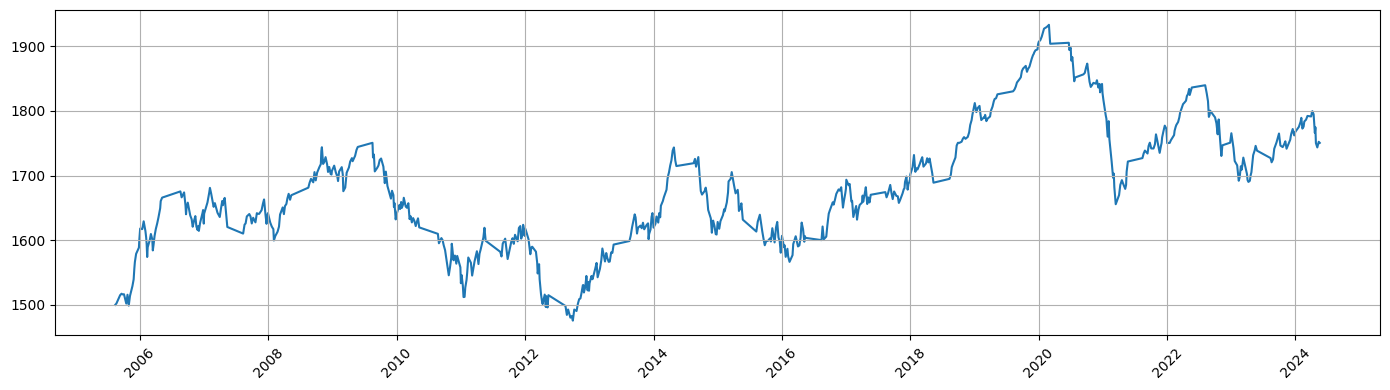

In [7]:
ELO_Liverpool = util.extract_elo_history(data, 'Liverpool')
ELO_Liverpool.set_index('Date', inplace=True)
util.plot_series(ELO_Liverpool['ELO'], figsize=figsize)

We see the rating is pretty average to the perception about how good they have been the last 20 years. The graph for example show a peak around 2020 when they won the league.

Lets see how the ELO difference between the teams affects the probability of a win, draw or loss

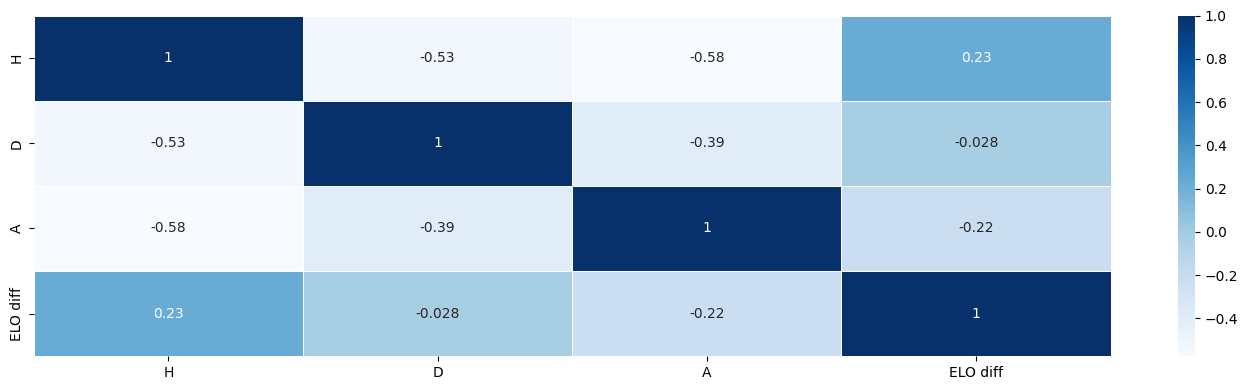

In [8]:
data = util.add_discrete_result_columns(data)
util.plot_correlation_matrix(data[['H', 'D', 'A', 'ELO diff']], figsize=figsize, annot=True)

From this we can see that ELO-rating has some predictive power, but the covariance is not "extreme". It does however give a good indication about the current strength of the teams.

## Predictions

Now that we have a assigned a probability of a home win for each match, we can use this to create a model to guess when there will be a home win. To do so, we will implement a cost model. For each match the predictor has two choices. It can either predict a home win or not. The outcome of the match has three possibilites, a home win, a draw or an away win. We will simplifiy it down to either a home win or not a howe win. From this we can get metrics for True Positive, True Negative, False positive and False negative:
- True Positive: The model predicts a home win, and there is a home win
- True Negative: The model predicts not a home win, and there is not a home win
- False Positive: The model predicts a home win, but there is not a home win
- False Negative: The model predicts not a home win, but there is a home win

With these metrics we create a simple cost model. We use this cost model to find the optimal probability threshold for predicting a home win. We will use this threshold to predict the outcome of the matches.

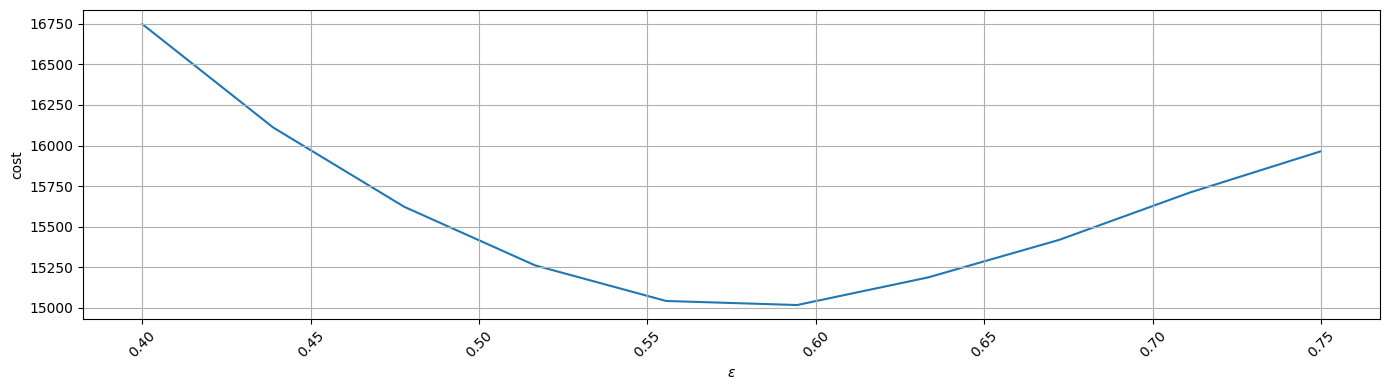

In [9]:
cost_model = util.SimpleCostModel(wrong=1, missed=1)
thr_range = np.linspace(0.4, 0.75, 10)
cost_range = pd.Series(index=thr_range, data=[cost_model.cost(data, thr) for thr in thr_range])
util.plot_series(cost_range, figsize=figsize, xlabel=r'$\varepsilon$', ylabel='cost')

In [10]:
best_thr, best_cost = util.opt_thr(data,  cost_model, thr_range)
print(f'Best threshold: {best_thr:.3f}, corresponding cost: {best_cost:.3f}')
print(f'Hit rate: {(1 - best_cost/len(data))*100:.3f}')

Best threshold: 0.594, corresponding cost: 15018.000
Hit rate: 60.911
